<a href="https://colab.research.google.com/github/TuckerArrants/computer-vision/blob/master/training-on-tpu-with-flower-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classification with TPUs

**In the past 5 years or so, machine learning models have been able to outperform humans on image classification tasks. What started as distinguishing between horses and humans has now evolved to detecting melanoma in images of moles with over 96% accuracy. This is largly because of transfer learning - the practice of importing pretrained models that are already intelligent and using them for your own task**

**But these models are deep and wide convolutional neural networks, with tens of millions of parameters that make training on regular hardware almost impossible. Luckily, there are tensor processing units (TPUs), hardware accelerators that are specifically designed for these deep learning tasks. The TPU available through Kaggle has 8 TPU cores which means we can funnel our data through 8 different channels, drastically decreasing computation time**

**Before we begin, thank you  to the starter kernel which helped kickstart this notebook. It can be found [here](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu)**

In [1]:
#the basics
from matplotlib import pyplot as plt
import math, os, re
import numpy as np, pandas as pd

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

Currently using Tensorflow version 2.3.0


# I. Configuration

**To take advantage of TPUs, we have to do some extra work. For the uninitiated, [this](http://www.tensorflow.org/guide/tpu) is an excellent place to start. We start by checking to see if TensorFlow is using a TPU or not - if it isn't, we set the 'strategy' to its default, which works on CPU and a single GPU, though we will definitely need to use the TPU for the current parameter setups of this notebook (if you use smaller image sizes, you might get away with running on CPU/GPU)**

In [2]:
DEVICE = 'TPU'   #or GPU

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
#REPLICAS = 8
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.21.142.10:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.21.142.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.142.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [3]:
#can use this path in Google Colabs if you want to host notebook else where
GCS_DS_PATH = 'gs://kds-fe723e79f544f8e3dd284d007e8e6a7809c77d389912c96a0c0d7510'

**To optimize the TPUs bandwith, we cut our dataset into files and then send these files to the different TPU cores. The common format for these files is TFRecords which essentially just takes the pixels of the image and some other information (e.g. a label) and stuffs it into a file. A good number of TFRecord files is 16: so we take our dataset and split it into 16 different TFRecord files and send them to the TPUs**

**Note: we need to modify some parameters accordingly because of this, most notably, we need to multiply whatever batch size we intend to use for our model(s) by 16**

In [4]:
#for reproducibility
SEED = 34     #my favorite number

#define image size we will use
IMAGE_SIZE = [224, 224]               #if you are using GPU
#IMAGE_SIZE = [331, 331]               #middle ground
#IMAGE_SIZE = [512, 512]               #if you are using TPU

#how many training samples we want going to TPUs 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 

#define aug batch size
AUG_BATCH = BATCH_SIZE

#how many folds we will use to train our model on
FOLDS = 3

#how many TTA steps to apply
TTA = 25

#list other options we have for image sizes
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

**Now we need to create some functions that allow us to extract information from these `TFRecords`. We will create functions that read the image and label from the `TFRecords`. For more about this, see [here](http://www.tensorflow.org/tutorials/load_data/tfrecord)**

**We can also perform some easy augmentations to be used during training and also for test time augmentation. For a quick reference on using `tf.image` to perform image augmentation, see [this](http://www.tensorflow.org/tutorials/images/data_augmentation)**

**Note: to achieve peak performance, we can use a pipeline that 'prefetches' data for the next step before the current step has finished using `tf.data`. You can learn more [here](http://www.tensorflow.org/guide/data_performance)**

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    #returns a dataset of (image, label) pairs
    return image, label

def read_unlabeled_tfrecord(example, return_image_name):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # [] means single entry
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    #returns a dataset of image(s)
    return image, idnum if return_image_name else 0

#some simply image augmentation we can perform with tf.image
def data_augment(image, label):
    
    #random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_hue(image, 0.01)
    #image = tf.image.random_saturation(image, 0.7, 1.3)
    #image = tf.image.random_contrast(image, 0.8, 1.2)
    #image = tf.image.random_brightness(image, 0.1)
    
    #fixed augmentations
    #image = tf.image.adjust_saturation(image, max_delta = .2)
    #image = tf.image.central_crop(image, central_fraction = 0.5)
    return image, label  

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [6]:
#define pre fetching strategy
AUTO = tf.data.experimental.AUTOTUNE

#use tf.io.gfile.glob to find our training and test files from GCS bucket
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
    
#show item counts
NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


In [7]:
def get_train_ds(files, tta_aug = False, cutmix_aug = False, shuffle = True, 
                 repeat = True, labeled=True, return_image_names = True):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO) 
    
    if tta_aug:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(transform, num_parallel_calls=AUTO)
    
    if cutmix_aug: 
        #need to batch to use CutMix/mixup
        ds = ds.batch(AUG_BATCH)
        ds = ds.map(mixup_and_cutmix, num_parallel_calls=AUTO) # note we put AFTER batching
        
        #now unbatch and shuffle before re-batching
        ds = ds.unbatch()
        #ds = ds.shuffle(2048)
    
    #prefetch next batch while training
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)
    
    return ds


def get_val_ds(files, shuffle = True, labeled=True, return_image_names=False):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()  
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)
        
    
    #prefetch next batch while training
    ds = ds.batch(BATCH_SIZE)
    
    #we must one hot encode if we use CutMix or mixup
    ds = ds.map(onehot, num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)
    
    return ds


# II. Visualization

**Now that we have dealt with all the configuring required to use TPUs, we can extract our images from the TPU and finally get a look at our data:**

In [8]:
#define flower classes for labeling purposes
classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

**Define some helper functions to plot our flower images:**

In [9]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [10]:
#first look at training dataset
training_dataset = get_train_ds(TRAINING_FILENAMES, cutmix_aug = False, tta_aug = False, labeled = True,
                                        shuffle = True, repeat = True)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [11]:
#first look at test dataset
test_dataset = get_train_ds(TEST_FILENAMES, labeled = False, shuffle = True, repeat = False)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

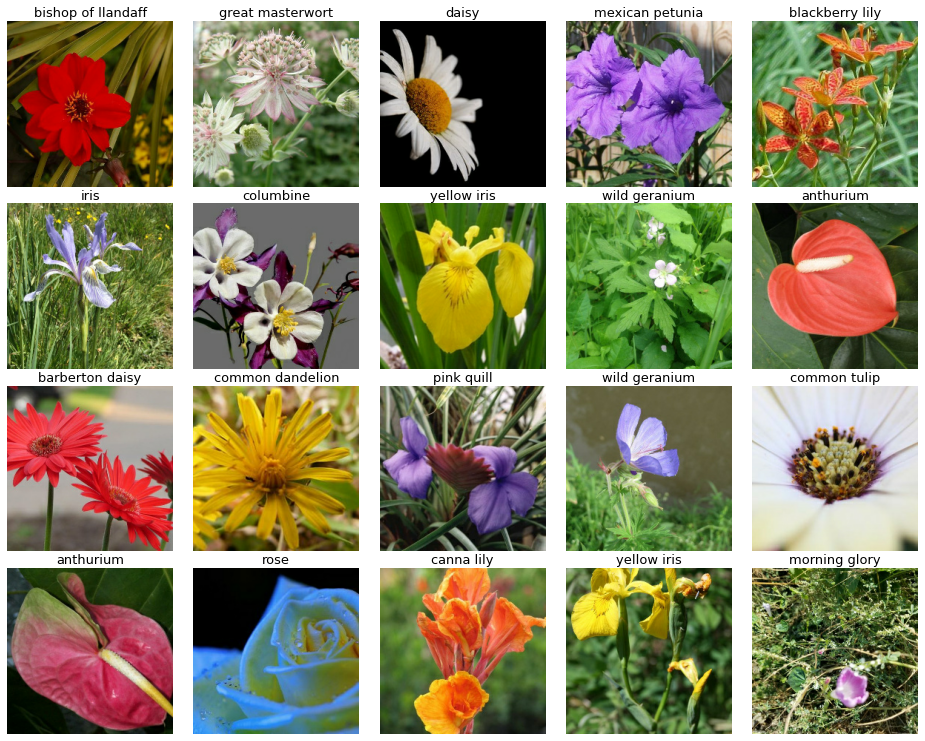

In [12]:
#view batch of flowers from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

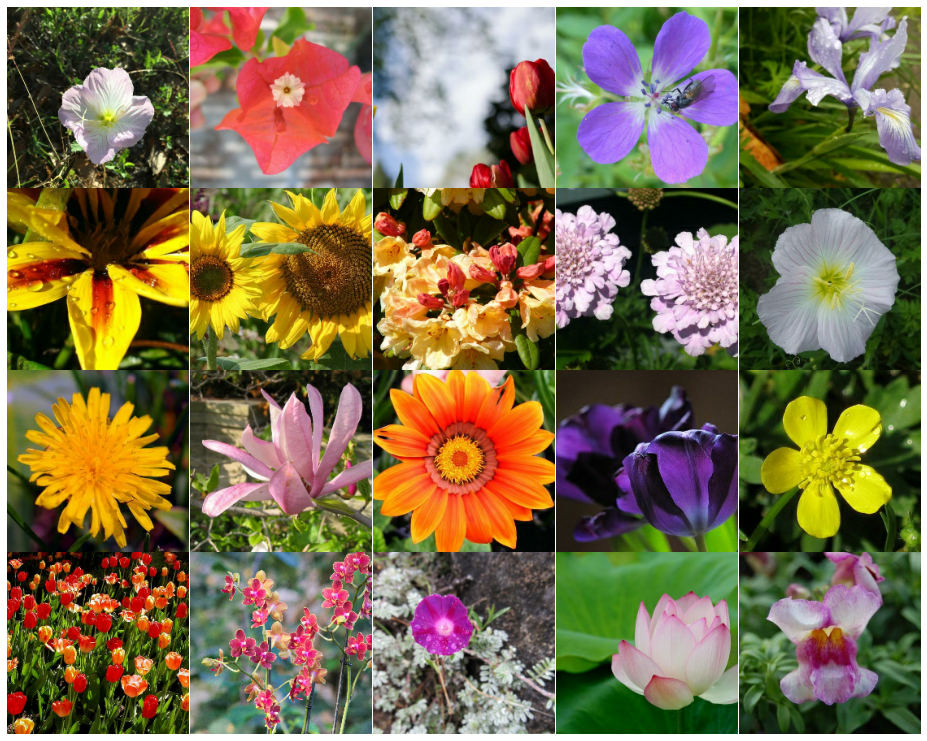

In [13]:
#view batch of flowers from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

# III. Augmentation

**Note: the following augmentation implementations are taken from (4X Kaggle Grandmaster) [Chris Deotte](https://www.kaggle.com/cdeotte)'s notebook, which can be found [here](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu) and [here](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96). We will define CutMix and mixup functions to apply during training and a rotation/shift/shearing function to apply during testing for TTA**

### Rotation, Shift, Zoom, Shear

In [14]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
    
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [15]:
def transform(image,label):
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 

    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
         
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

### mixup

**Now, the augmentation we did above is great, but we are still adding noise to the images which is also leading to information loss. Luckily, we can do better with mixup. Essentially, all mixup does is random converts images to convex combinations of pairs of images and their labels, as seen in the illustration below:**

![mixup](http://miro.medium.com/max/362/0*yLCQYAtNAh28LQks.png)
Image from [here](http://medium.com/swlh/how-to-do-mixup-training-from-image-files-in-keras-fe1e1c1e6da6)

**We can see that we retain information about both images and their labels while introducing regularization into our model. For more on MixUp, read [this](https://arxiv.org/abs/1710.09412)**

In [16]:
#need to one hot encode images so we can blend their labels like above
def onehot(image,label):
    CLASSES = len(classes)
    return image,tf.one_hot(label,CLASSES)

In [17]:
def mixup(image, label, PROBABILITY = 1.0):
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0

        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)

        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

### CutMix

**CutMix is essentially the same as mixup except the images are not blended together, rather a random sized block of one image is superimposed on another image. You can read more about it [here](http://arxiv.org/pdf/1905.04899.pdf)**

In [18]:
#first look at test dataset
test_dataset = get_train_ds(TEST_FILENAMES, cutmix_aug = False, tta_aug = False, labeled = False,
                                        shuffle = True, repeat = False)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [19]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)

        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
        
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

### mixup and CutMix

**It is hard to choose which is better, mixup or CutMix. Luckily, we don't actually have to choose because we can just apply both:**

**Note: CutMix will occur `SWITCH * CUTMIX_PROB` of the time and mixup will occur `(1 - SWITCH) * MIXUP_PROB` of the time. We will need to experiment a bit to see which convex combination delivers the best performance**

**The current setup gives us mixup 33% of the time, CutMix 33% of the time, and no augmentation 33% of the time**

In [20]:
#create function to apply both cutmix and mixup
def mixup_and_cutmix(image,label):
    CLASSES = len(classes)
    DIM = IMAGE_SIZE[0]
    
    #define how often we want to do activate cutmix or mixup
    SWITCH = 1/2
    
    #define how often we want cutmix or mixup to activate when switch is active
    CUTMIX_PROB = 2/3
    MIXUP_PROB = 2/3
    
    #apply cutmix and mixup
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    
    for j in range(BATCH_SIZE):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
        
    #must explicitly reshape so TPU complier knows output shape
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
    return image4,label4

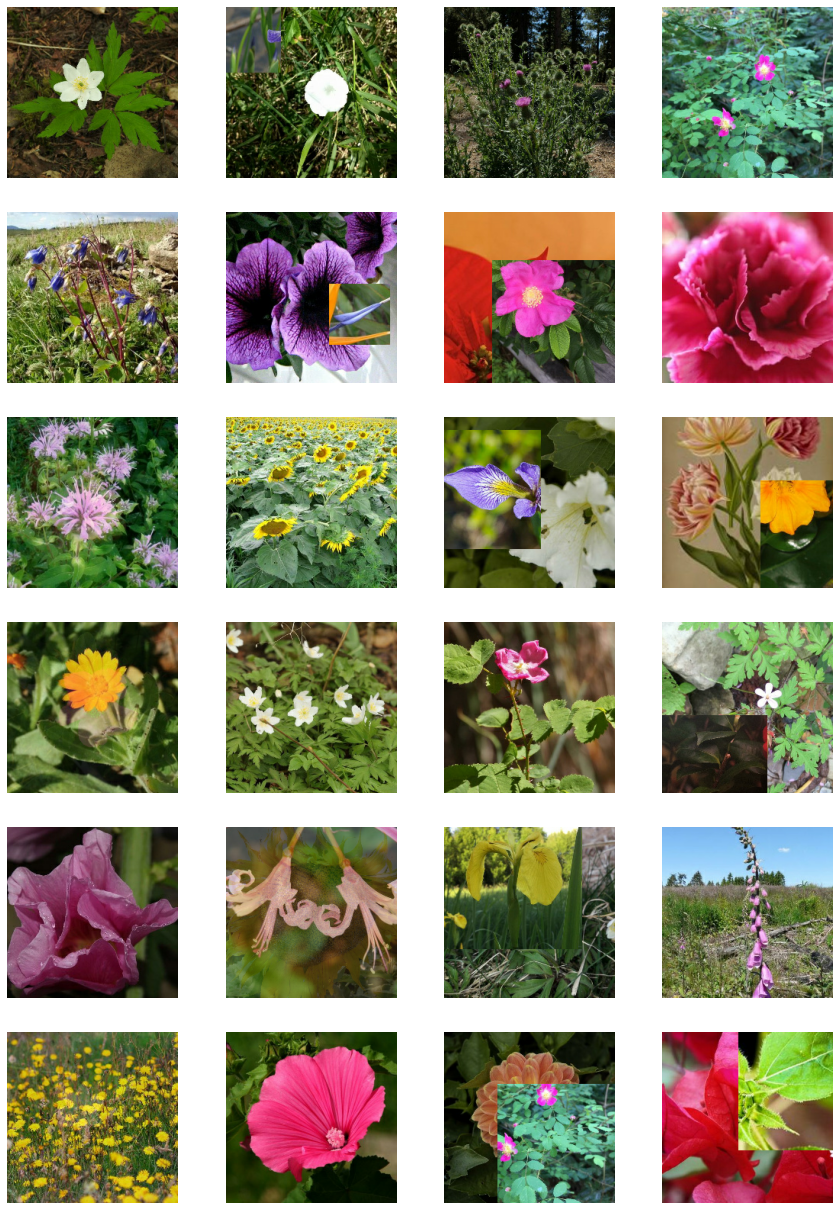

In [21]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_train_ds(TRAINING_FILENAMES, cutmix_aug = True, tta_aug = False, labeled = True,
                                        shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# IV. Model Training

**Now, it will take far too much time for us to train a model ourselves to learn the optimal weights for classifying our flower photos, so we will instead import a model that has already been pre-trained on ImageNet: a large labeled dataset of real-world images**

**We will be importing several popular pre-trained models. For a list of all the pre-trained models that can be imported with Keras, see [here](https://keras.io/api/applications/)**

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


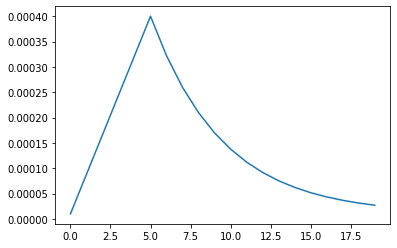

In [22]:
#define epoch parameters
EPOCHS = 20                
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // BATCH_SIZE

#define learning rate parameters
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#define ramp up and decay
def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lr_schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**If you decide to use an EfficientNet model for your final model, you need to install something as it is not yet supported by `keras.applications`. There is another weight option for EffNets to consider that outperforms Imagenet weights called 'Noisy Student' that you can read about [here](https://arxiv.org/abs/1911.04252). For more on EffNets in general, read [this](https://arxiv.org/pdf/1905.11946.pdf)**

In [25]:
#import DenseNet201, Xception, InceptionV3, and InceptionResNetV2
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3, InceptionResNetV2

#requirements to use EfficientNet(s)
!pip install -q efficientnet
import efficientnet.tfkeras as efn

#helper function to create our model
def get_DenseNet201():
    CLASSES = len(classes)
    with strategy.scope():
        dnet = DenseNet201(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        dnet.trainable = True
        model = tf.keras.Sequential([
            dnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    return model

#create Xception model
def get_Xception():
    CLASSES = len(classes)
    with strategy.scope():
        xception = Xception(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        xception.trainable = True
        model = tf.keras.Sequential([
            xception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create Inception model
def get_InceptionV3():
    CLASSES = len(classes)
    with strategy.scope():
        inception = InceptionV3(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception.trainable = True
        model = tf.keras.Sequential([
            inception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB4 model
def get_EfficientNetB4():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB4(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB5 model
def get_EfficientNetB5():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create EfficientNetB6 model
def get_EfficientNetB6():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB6(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB7 model
def get_EfficientNetB7():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB7(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create InceptionResNet model
def get_InceptionResNetV2():
    CLASSES = len(classes)
    with strategy.scope():
        inception_res = InceptionResNetV2(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception_res.trainable = True
        model = tf.keras.Sequential([
            inception_res,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

**To make our model even more robust, we can also split our data into different folds during training. For example, if `FOLDS = 5`, we would split our data into 5 different folds, train on the first 4 folds, and then validate on the remaining fold. We then repeat this process and cycle through the folds until we have 5 different models that have been trained and validated on 5 different datasets. We then generate predictions with each one of these trained models and take the average of all 5 predictions as our final predictions:**

**(Recall that the `FOLDS` parameter was defined much earlier in the notebook as it was needed to determine the size of the validation set)**

In [27]:
from sklearn.model_selection import KFold
#train and cross validate in folds


histories = []
models = []
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)

#break into different fodls
for f, (train_index, val_index) in enumerate(kfold.split(TRAINING_FILENAMES)):
#to clear the TPU memory each fold
    #tf.tpu.experimental.initialize_tpu_system(tpu)
    print(); print('--'*25)
    print(f"Training fold {f + 1} with EfficientNetB4")
    print('--'*25)
    print('Getting training data...')
    print('')
    #get files for training and validation   
    train_ds = get_train_ds(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']),
                                    cutmix_aug = True, tta_aug = False, labeled = True, shuffle = True, repeat = True)
    
    print('Geting validation data...')
    print('')
    val_ds = get_val_ds(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']),
                            labeled = True, shuffle = True, return_image_names = False)
              
    #train and cross validate
    model = get_EfficientNetB4()
    history = model.fit(train_ds, 
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs = EPOCHS,
                        callbacks = [lr_callback], #,early_stopping]
                        validation_data = val_ds,
                        verbose = 2)
    models.append(model)
    histories.append(history)


-------------------------
Training fold 1 with DenseNet201
-------------------------
Getting training data...

Geting validation data...

74842112/74836368 [==============================] - 3s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


128/128 - 78s - loss: 4.2826 - categorical_accuracy: 0.1179 - val_loss: 3.4157 - val_categorical_accuracy: 0.2940

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
128/128 - 44s - loss: 2.3515 - categorical_accuracy: 0.5513 - val_loss: 0.9110 - val_categorical_accuracy: 0.7880

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
128/128 - 45s - loss: 1.5431 - categorical_accuracy: 0.7418 - val_loss: 0.6240 - val_categorical_accuracy: 0.8711

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
128/128 - 45s - loss: 1.3249 - categorical_accuracy: 0.7939 - val_loss: 0.6240 - val_categorical_accuracy: 0.8675

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
128/128 - 45s - loss: 1.2443 - categorical_accuracy: 0.8033 - val_loss: 0.8136 - val_categorical_accuracy: 0.8297

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/20
128/128 - 45s - lo

128/128 - 78s - loss: 4.2418 - categorical_accuracy: 0.1205 - val_loss: 3.4436 - val_categorical_accuracy: 0.2679

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
128/128 - 44s - loss: 2.3572 - categorical_accuracy: 0.5445 - val_loss: 1.0100 - val_categorical_accuracy: 0.7826

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
128/128 - 45s - loss: 1.5473 - categorical_accuracy: 0.7397 - val_loss: 0.6516 - val_categorical_accuracy: 0.8640

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
128/128 - 44s - loss: 1.3322 - categorical_accuracy: 0.7896 - val_loss: 0.6220 - val_categorical_accuracy: 0.8731

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
128/128 - 44s - loss: 1.2409 - categorical_accuracy: 0.8020 - val_loss: 0.6490 - val_categorical_accuracy: 0.8578

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/20
128/128 - 45s - lo

128/128 - 79s - loss: 4.2964 - categorical_accuracy: 0.1229 - val_loss: 3.4284 - val_categorical_accuracy: 0.2975

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
128/128 - 45s - loss: 2.3377 - categorical_accuracy: 0.5575 - val_loss: 0.9251 - val_categorical_accuracy: 0.8029

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
128/128 - 45s - loss: 1.5561 - categorical_accuracy: 0.7387 - val_loss: 0.7005 - val_categorical_accuracy: 0.8520

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
128/128 - 45s - loss: 1.3123 - categorical_accuracy: 0.7946 - val_loss: 0.6798 - val_categorical_accuracy: 0.8585

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
128/128 - 46s - loss: 1.2295 - categorical_accuracy: 0.8086 - val_loss: 0.6704 - val_categorical_accuracy: 0.8625

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/20
128/128 - 46s - lo

In [28]:
#define function to visualize learning curves
def plot_learning_curves(histories): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    
    #plot accuracies
    for i in range(0, 3):
        ax[0].plot(histories[i].history['categorical_accuracy'], color = 'C0')
        ax[0].plot(histories[i].history['val_categorical_accuracy'], color = 'C1')

    #plot losses
    for i in range(0, 3):
        ax[1].plot(histories[i].history['loss'], color = 'C0')
        ax[1].plot(histories[i].history['val_loss'], color = 'C1')

    #fix legend
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')
    
    #set master titles
    fig.suptitle("Model Performance", fontsize=14)
    
    #label axis
    for i in range(0,2):
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')

    return plt.show()

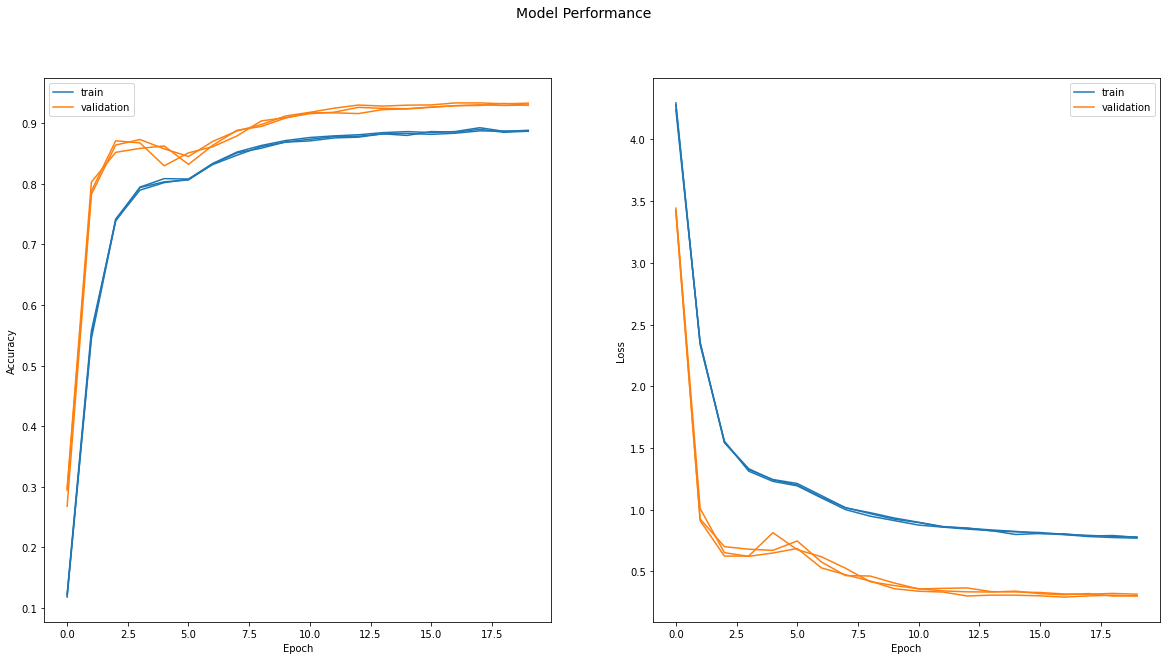

In [29]:
#look at our learning curves to check bias/variance trade off
plot_learning_curves(histories)

# V. Test Time Augmentation

**Now we can perform augmentation on the test set as well. We will augment each image `TTA` many times and predict on each. Then we average the results of those predictions and use that as our final prediction. We cannot use CutMix/MixUp because they use label blending techniques (of which we have none in the test set) so we use the transformations with in the `data_augment` function and the rotation/shear/shift augmentation we defined earlier in the `transform` function:**

In [30]:
def get_test_dataset(filenames, shuffle = False, repeat = True, labeled = False, tta_aug = True, return_image_names = True):

    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)

    if tta_aug:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        #ds = ds.map(transform, num_parallel_calls=AUTO)
    
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)

    return ds

In [31]:
def average_tta_preds(tta_preds):
    average_preds = np.zeros((ct_test, 104))
    for fold in range(FOLDS):
        average_preds += tta_preds[(fold)*ct_test:(fold + 1)*ct_test] / FOLDS
    return average_preds

In [32]:
#since we are splitting the dataset and iterating separately on images and ids, order matters.
test_ds = get_test_dataset(TEST_FILENAMES, tta_aug = True, labeled = False,
                           repeat = True, return_image_names = True)
test_images_ds = test_ds.map(lambda image, idnum: image)
    
#set up TTA
ct_test = count_data_items(TEST_FILENAMES)
STEPS = TTA * ct_test/BATCH_SIZE

#predict  
print('Getting TTA predictions...')
pred0 = models[0].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
pred1 = models[1].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
pred2 = models[2].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
print('')

#get averages of each augmentation
print('Averaging TTA predictions...')
average_pred0 = average_tta_preds(pred0)
average_pred1 = average_tta_preds(pred1)
average_pred2 = average_tta_preds(pred1)
print('')

#merge together and average
print('Merging predictions from models...')
final_preds = np.zeros((ct_test, 104))
final_preds += average_pred0
final_preds += average_pred1
final_preds += average_pred2

#and take argmax to get in label form
final_preds = np.argmax(final_preds, axis = 1)

#lastly, get test ids for submission
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
print('Done')

Getting TTA predictions...


1442/1441 - 149s


1442/1441 - 148s


1442/1441 - 149s

Averaging TTA predictions...

Merging predictions from models...
Done


In [33]:
#create submission dataframe
submission = pd.DataFrame()
submission['id'] = test_ids
submission['label'] = final_preds
print(submission.shape)
submission.head(10)

(7382, 2)


id  label
0  252d840db     67
1  1c4736dea     28
2  c37a6f3e9     83
3  00e4f514e    103
4  59d1b6146     46
5  8d808a07b     53
6  aeb67eefb     52
7  53cfc6586     29
8  aaa580243     82
9  d907ca7c0     13

In [34]:
#submit to disk
submission.to_csv('submission.csv', index = False)
print('Submission saved')

Submission saved


# VI.Past Results

**New version**  
TTA = 5  
1)EfficientNetB6 
2)EfficientNetB6  
3)EfficientNetB6   
Epochs = 25  
LB = ?

**Previous versions:**  
1)EfficientNetB5  
2)DenseNet201  
3)EfficientNetB5  
Epochs = 25  
LB = 0.96380

1)InceptionResNetV2  
2)DenseNet201  
3)EfficientNetB5  
Epochs = 25  
LB = 0.96290

1)EfficientNetB5  
2)EfficientNetB5  
3)EfficientNetB5  
Epochs = 25  
LB = 0.96623

Added test time augmentation; TTA = 5  
1)EfficientNetB5  
2)EfficientNetB5  
3)EfficientNetB5  
Epochs = 25  
LB = 0.95455

TTA = 5  
1)EfficientNetB6  
2)EfficientNetB6  
3)EfficientNetB6   
Epochs = 20  
LB = 0.94769